In [1]:
include("../src/ColdAtoms.jl")
using .ColdAtoms

In [2]:
using PyPlot
using QuantumOptics
using BenchmarkTools

TimeDependentSum can cause data race

In [14]:
#Default simulation parameters
include("../params/default.jl")

N = 300;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);

Ωr = 2π * 5.0 * 35.0;
red_laser_params = [Ωr, wr, zr];
detuning_params = [Δ0, δ_twophoton(Ωr, Ωb, Δ0)];

T0 = T_twophoton(Ωr, Ωb, Δ0);
tspan = [0.0:T0/30:2.5*T0;];
ψ0 = g;

In [27]:
Ωr_required(2π*4.0, 2π * 60.0, 2π * 904) / (2π)

120.53333333333335

In [17]:
ρ_mean, ρ2_mean = 
    simulation(
        tspan, ψ0, 
        
        atom_params,
        trap_params,
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        parallel=false
    );

In [23]:
function add_contrast(Pg, Pr, ϵ, ϵt, η)
    Pg_temp = η*(1.0 - ϵ) .+ (1.0 - η)*(1.0 - ϵ)*(Pg + ϵt * Pr);
    Pr_temp = η*ϵ .+ (1.0 - η)*(ϵ*Pg + (1.0 - ϵt + ϵ*ϵt)*Pr);
    return Pg_temp, Pr_temp
end;

ϵ, ϵt, η = 0.1, 0.2, 0.0

(0.1, 0.2, 0.0)

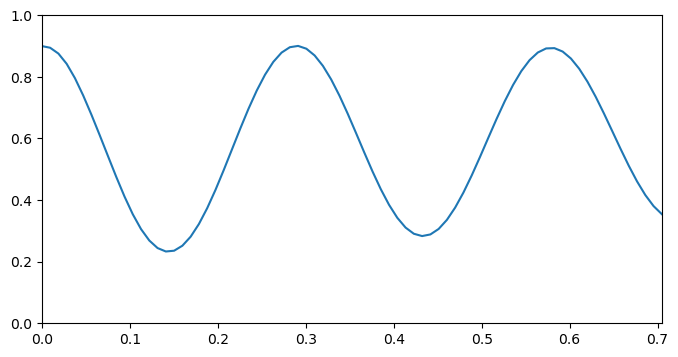

In [24]:
Pg = real(expect(g ⊗ dagger(g), ρ_mean)); 
Pr = real(expect(r ⊗ dagger(r), ρ_mean));
Pg_temp, Pr_temp = add_contrast(Pg, Pr, ϵ, ϵt, η);

figure(figsize=(8,4))
plot(tspan / (maximum(tspa)), 1.0 .- Pr_temp)
xlim(0.0, maximum(tspan))
ylim(0.0, 1.0)
gcf()

In [5]:
tspan = [0.0:T0/20:2.5*T0;];
@time simulation(
    tspan, ψ0, 
    
    atom_params,
    trap_params,
    samples,
    
    f,
    red_laser_phase_amplitudes,
    blue_laser_phase_amplitudes,
    
    red_laser_params,
    blue_laser_params,
    
    detuning_params,
    decay_params
);

 33.819570 seconds (142.80 M allocations: 4.873 GiB, 2.77% gc time)


In [32]:
tspan = [0.0:0.01:1.0;];

function test1(N)
    ψ = [[zero(g) for _ in 1:length(tspan)] for _ in 1:N];
    f(t) = 0.0;
    H1 = TimeDependentSum([f, f], [g ⊗ dagger(p), p ⊗ dagger(g)]);

    for i in 1:N
        f(t, i) = sin(t * i)
        H1.coefficients = [t -> f(t, i)];
        H1.current_time = 0.0;
        _, ψ[i] = timeevolution.schroedinger_dynamic(tspan, g, H1)
    end;

    return ψ
end;


function test2(N)
    ψ = [[zero(g) for _ in 1:length(tspan)] for _ in 1:N];

    for i in 1:N
        H2 = TimeDependentSum([t -> sin(t*i), t -> sin(t*i)], [g ⊗ dagger(p), p ⊗ dagger(g)]);
        _, ψ[i] = timeevolution.schroedinger_dynamic(tspan, g, H2)
    end;
    return ψ
end;


ψ1, ψ2, = test2(2);

ψ3, ψ4, = test1(2);


figure()
plot(tspan, expect(g ⊗ dagger(g), ψ1))
plot(tspan, expect(g ⊗ dagger(g), ψ3))
plot(tspan, expect(g ⊗ dagger(g), ψ2))
plot(tspan, expect(g ⊗ dagger(g), ψ4))
gcf()

MethodError: MethodError: Cannot `convert` an object of type var"#377#381"{Int64} to an object of type var"#f#380"

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:64


In [15]:
fieldnames(typeof(H))


0.0

In [7]:
tspan = [0.0:T0/20:2.5*T0;];
@time ColdAtoms.simulation_parallel(
    tspan, ψ0, 
    
    atom_params,
    trap_params,
    samples,
    
    f,
    red_laser_phase_amplitudes,
    blue_laser_phase_amplitudes,
    
    red_laser_params,
    blue_laser_params,
    
    detuning_params,
    decay_params
);

  0.000068 seconds (1.05 k allocations: 145.547 KiB)


In [ ]:
100 * 0.15